COMP9414 Assignment 1

Yixuan Lu

z5577113

I leave some comments between code to describe what the code does.


*   use linear interpolation to handling missing data
*   convert date and time information into numerical features
*   use minmaxScaler to preprocess data for classification task
*   for the classification task:
1.   use ReLU activation function in hidden layers
2.   use sigmoid activation function in the output layer
1.   use binary cross-entropy as the loss function
*   for the regression task:
1.   use ELU activation function in hidden layers
1.   use mean squared error as the loss function

*   for testing generalisation set:
1.   put the generalisation set into the same directly with this assignment
1.   modify the name of file in file_path_test = 'AirQualityUCI _ Students.xlsx'
2.   execute the cell



In [3]:
# #I use google colab to unload my dataset and run code.
# from google.colab import files

# uploaded = files.upload()
# file_name = next(iter(uploaded))
# data = pd.read_excel(file_name)
import os
print(os.listdir('.'))

['.ipynb_checkpoints', '9414A1.ipynb', 'AirQualityUCI _ Students.xlsx']


In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

file_path = 'AirQualityUCI _ Students.xlsx'
data = pd.read_excel(file_path)
# file_name = next(iter(uploaded))
# data = pd.read_excel(file_name)


# file_path = 'AirQualityUCI_Students.xlsx'
# data = pd.read_excel(file_path)

#need to mark missing values as NaN for pandas before calling interpolate
data.replace(-200, np.nan, inplace=True)

# #outlier
# #get column
# numeric_cols = data.select_dtypes(include=[np.number]).columns
# #calculate Z-score using pandas
# data_zscore = (data[numeric_cols] - data[numeric_cols].mean()) / data[numeric_cols].std()
# outliers = (data_zscore.abs() > 3)
# data = data[~outliers.any(axis=1)]

#learn interpolate from https://www.geeksforgeeks.org/pandas-dataframe-interpolate/ and https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate
data.interpolate(method='linear', inplace=True)
print(data.isnull().sum())

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64


C:\Users\lu\AppData\Local\Temp\ipykernel_20496\1443976044.py:30: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(method='linear', inplace=True)


In [26]:
#convert date and time information into numerical features
data['DayOfYear'] = pd.to_datetime(data['Date'], format='%Y-%m-%d').dt.dayofyear
data['HourOfDay'] = pd.to_datetime(data['Time'], format='%H:%M:%S').dt.hour
#calculate avg mean of co and add an feature CO_INT
co_mean = data['CO(GT)'].mean()
data['CO_INT'] = (data['CO(GT)'] > co_mean).astype(int)
#remove meaningless feature
features = data.drop(columns=['Date', 'Time', 'CO(GT)', 'CO_INT'])
labels = data['CO_INT']

#use min max scaler learn from https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
#check the correctness print first to tuples
features_df = pd.DataFrame(scaled_features, columns=features.columns)
print(features_df.head(2))

#learn train_test_split from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
#42 is the answer to everything
train_features, test_features, train_labels, test_labels = train_test_split(scaled_features, labels, test_size=0.2, random_state=42)
#create tf.data.Dataset
print ('Training Features Len:', len(train_features))
# train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).shuffle(buffer_size=len(train_features)).batch(32)
# test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(32)
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=len(train_features))
train_dataset = train_dataset.batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))
test_dataset = test_dataset.batch(32)

# #learn from https://www.tensorflow.org/api_docs/python/tf/data/Dataset
# dataset = tf.data.Dataset.from_tensor_slices((features.values, labels.values))
# dataset = dataset.shuffle(buffer_size=len(features))
# #use Random Split here with ratio 80/20
# train_size = int(len(features) * 0.8)
# train_dataset = dataset.take(train_size)
# test_dataset = dataset.skip(train_size)
# #learn from https://github.com/willisguo14/dpcnn/blob/master/model.py
# #batch the datasets
# batch_size = 32
# train_dataset = train_dataset.batch(batch_size)
# test_dataset = test_dataset.batch(batch_size)


   PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)   NOx(GT)  PT08.S3(NOx)  \
0     0.523888  0.120981  0.184498       0.361737  0.109831      0.311024   
1     0.474090  0.088832  0.145428       0.312167  0.067119      0.360796   

    NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)         T        RH        AH  \
0  0.328694      0.513040     0.454654  0.333333  0.508974  0.280046   
1  0.266509      0.453125     0.326382  0.326882  0.493910  0.264279   

   DayOfYear  HourOfDay  
0   0.189041   0.782609  
1   0.189041   0.826087  
Training Features Len: 6686


In [27]:
# this part is only for test purpose, no need to execute it
feature_shapes = []
label_shapes = []
for features, labels in test_dataset:
    feature_shapes.append(features.shape)
    label_shapes.append(labels.shape)


print("Feature shapes:", np.unique(feature_shapes, axis=0))
print("Label shapes:", np.unique(label_shapes, axis=0))
print("Feature dtype:", features.dtype)
print("Label dtype:", labels.dtype)
# Feature shapes: [[ 8 14]
#  [32 14]]
# Label shapes: [[ 8]
#  [32]]
# Feature dtype: <dtype: 'float64'>
# Label dtype: <dtype: 'int64'>
# batch=32 the remaining sample size is 8  each has 14 features
# 8 and 32 labels for coresponding samples

Feature shapes: [[ 8 14]
 [32 14]]
Label shapes: [[ 8]
 [32]]
Feature dtype: <dtype: 'float64'>
Label dtype: <dtype: 'int32'>


In [28]:
#we have 15 features in original dataset and we add 3 features and drop 4
#So, Nw=14
#by Rule of thumb: Nw=(Ni+1)*Hh1+(Nh1+1)*Hh2+(Nh2+1)*No=521<sample/10
def create_classification_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(features.shape[1],)),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    print(features.shape[1])
    print(model.summary())
    return model
#https://www.tensorflow.org/guide/keras/training_with_built_in_methods

# test code to try different epoches
#epochs_list = [25, 50, 150, 500]
# histories = []
# for epochs in epochs_list:
#     model = create_model()
#     optimizer = Adam(learning_rate=0.001)
#     loss_function = 'binary_crossentropy'
#     model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
#     history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)
#     histories.append(history)
#     test_loss,test_accuracy = model.evaluate(test_dataset)
#     print('Test Accuracy: %s' % test_accuracy)

epochs = 50
classification_model = create_classification_model()
optimizer = Adam(learning_rate=0.001)
loss_function = 'binary_crossentropy'
classification_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
history = classification_model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)
test_loss,test_accuracy = classification_model.evaluate(test_dataset)
print('Test Accuracy: %s' % test_accuracy)

14


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ (None, 20)                  │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 521 (2.04 KB)

 Trainable params: 521 (2.04 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6914 - loss: 0.6010 - val_accuracy: 0.8726 - val_loss: 0.3439
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.8569 - loss: 0.3618 - val_accuracy: 0.8738 - val_loss: 0.3041
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.8667 - loss: 0.3315 - val_accuracy: 0.8828 - val_loss: 0.2872
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.8767 - loss: 0.3106 - val_accuracy: 0.8882 - val_loss: 0.2773
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.8756 - loss: 0.3017 - val_accuracy: 0.8911 - val_loss: 0.2704
Epoch 6/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.8834 - loss: 0.2925 - val_accuracy: 0.8929 - val_loss: 0.2633
Epoch 7/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.8920 - loss: 0.2787 - val_accuracy: 0.8983 - val_loss: 0.2636
Epoch 8/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.8928 - loss: 0.2801

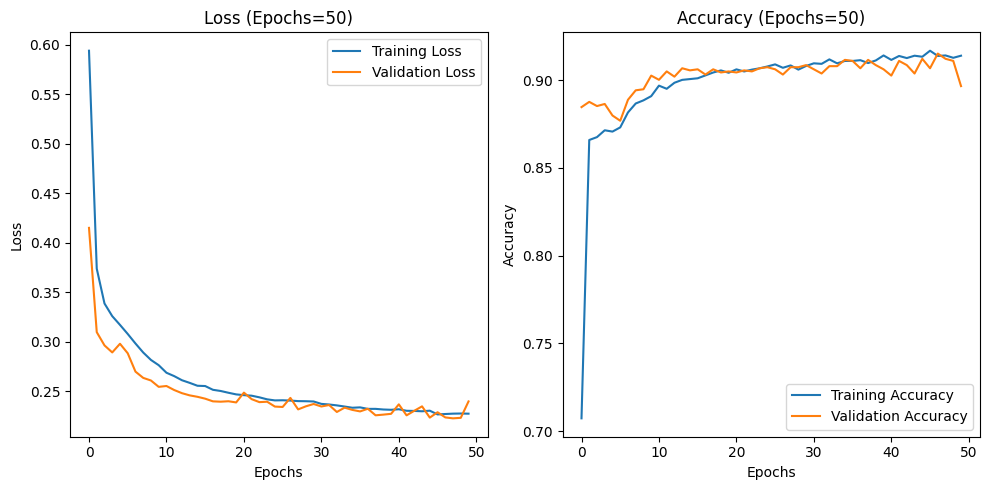

In [16]:
#learn from https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
# from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

# test code to try different epoches
# for i, epochs in enumerate(epochs_list):
#     # subplot(row,col,position)
#     plt.subplot(len(epochs_list), 2, 2*i + 1)
#     plt.plot(histories[i].history['loss'], label='Training Loss')
#     plt.plot(histories[i].history['val_loss'], label='Validation Loss')
#     plt.title('Loss (Epochs=%s)'% epochs)
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     #automatically determine legend's position
#     plt.legend()

# for i, epochs in enumerate(epochs_list):
#     plt.subplot(len(epochs_list), 2, 2*i + 2)
#     plt.plot(histories[i].history['accuracy'], label='Training Accuracy')
#     plt.plot(histories[i].history['val_accuracy'], label='Validation Accuracy')
#     plt.title('Accuracy (Epochs=%s)'% epochs)
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()

# subplot(row,col,position)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss (Epochs=%s)'% epochs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
#automatically determine legend's position
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy (Epochs=%s)'% epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#adjust subplot parameters ensure that subplots fit into the figure area without overlapping
plt.tight_layout()
plt.show()

#The validation loss shows more fluctuation when epochs>=100 which may indicate some level of overfitting, so I use epochs=50 here.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

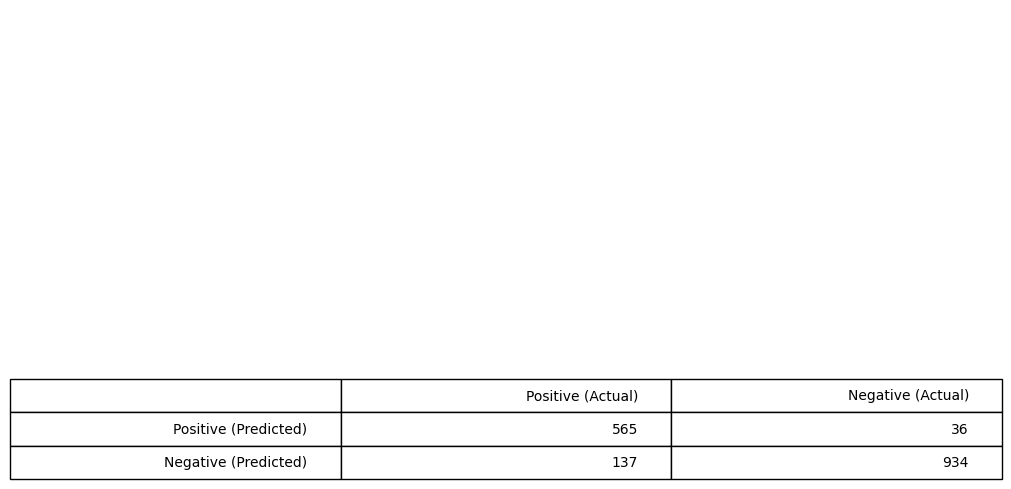

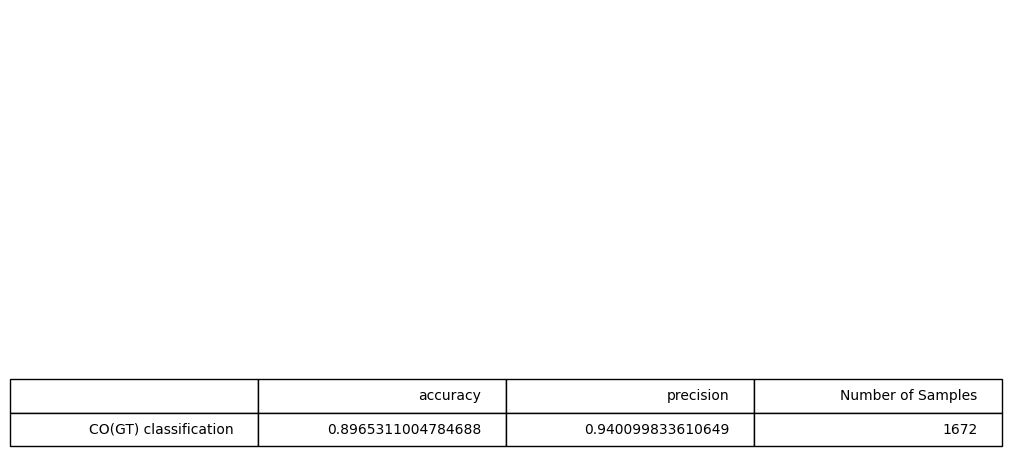

In [15]:
#learn confusion matrix from https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix
from sklearn.metrics import confusion_matrix

true_labels = []
predict_labels = []

for features, labels in test_dataset:
    true_labels.append(labels.numpy())
    predict_labels.append(classification_model.predict(features))
# 8358 # of data, 20% is test data so 1671 # of test data, batch size is 32, so 53 batches
print("size of predictions:", len(predict_labels))
#learn Joining NumPy Arrays https://www.w3schools.com/python/numpy/numpy_array_join.asp
true_labels = np.concatenate(true_labels)
predict_labels = np.concatenate(predict_labels)
print("predictions:", predict_labels)
#threshold is 0.5 for binary problem
predict_labels = (predict_labels>0.5).astype(int)
conf_matrix = confusion_matrix(true_labels, predict_labels)
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]
classification_accuracy = (TP + TN) / (TP + TN + FP + FN)
if (TP + FP) != 0:
    classification_precision = TP / (TP + FP)
else:
    classification_precision = 0

confusion_matrix_data = [['', 'Positive (Actual)', 'Negative (Actual)'],
        ['Positive (Predicted)', TP, FP],
        ['Negative (Predicted)', FN, TN]]
fig, ax = plt.subplots()
ax.axis('off')
table = ax.table(cellText=confusion_matrix_data)
table.scale(2, 2)
plt.show()

classification_precision_accuracy_data = [['', 'accuracy', 'precision','Number of Samples'],
        ['CO(GT) classification', classification_accuracy, classification_precision, len(test_labels) ]]
fig, ax = plt.subplots()
ax.axis('off')
table = ax.table(cellText=classification_precision_accuracy_data)
table.scale(2, 2)
plt.show()

For regression task, I only do some small modification base on my previous  code

In [20]:
# file_name = next(iter(uploaded))
# data = pd.read_excel(file_name)
# data.replace(-200, np.nan, inplace=True)
# data.interpolate(method='linear', inplace=True)
# data['DayOfYear'] = pd.to_datetime(data['Date'], format='%Y-%m-%d').dt.dayofyear
# data['HourOfDay'] = pd.to_datetime(data['Time'], format='%H:%M:%S').dt.hour

features = data.drop(columns=['Date', 'Time', 'CO_INT', 'NOx(GT)'])
labels = data['NOx(GT)']

scaler_features = MinMaxScaler()
scaled_features = scaler_features.fit_transform(features)

train_features, test_features, train_labels, test_labels = train_test_split(scaled_features, labels, test_size=0.2, random_state=42)

scaler_labels = MinMaxScaler()
train_labels = scaler_labels.fit_transform(train_labels.values.reshape(-1, 1))
test_labels = scaler_labels.transform(test_labels.values.reshape(-1, 1))

train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=len(train_features))
train_dataset = train_dataset.batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))
test_dataset = test_dataset.batch(32)
# we dont need activation function since we need output a continuous data
def create_regression_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(train_features.shape[1],)),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    return model
regression_model = create_regression_model()
regression_model.summary()
optimizer = Adam(learning_rate=0.001)
loss_function = 'mean_squared_error'
regression_model.compile(optimizer=optimizer, loss=loss_function, metrics=['mae'])
history = regression_model.fit(train_dataset, epochs=50, validation_data=test_dataset)
# need to get Mean Absolute Error
test_loss,test_mae = regression_model.evaluate(test_dataset)
print('Test Mean Absolute Error: %s' % test_mae)

test_predictions = regression_model.predict(test_features).flatten()
test_predictions = scaler_labels.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
test_labels = scaler_labels.inverse_transform(test_labels).flatten()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 20)                  │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 521 (2.04 KB)

 Trainable params: 521 (2.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0230 - mae: 0.1074 - val_loss: 0.0056 - val_mae: 0.0552
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 0.0051 - mae: 0.0500 - val_loss: 0.0038 - val_mae: 0.0435
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0035 - mae: 0.0413 - val_loss: 0.0033 - val_mae: 0.0413
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 0.0028 - mae: 0.0365 - val_loss: 0.0025 - val_mae: 0.0328
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 0.0024 - mae: 0.0328 - val_loss: 0.0022 - val_mae: 0.0311
Epoch 6/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 0.0021 - mae: 0.0310 - val_loss: 0.0021 - val_mae: 0.0319
Epoch 7/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 0.0020 - mae: 0.0306 - val_loss: 0.0020 - val_mae: 0.0298
Epoch 8/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 0.0019 - mae: 0.0301 - val_loss: 0.0019 - val_mae: 0.0293
Epoch 9/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 9

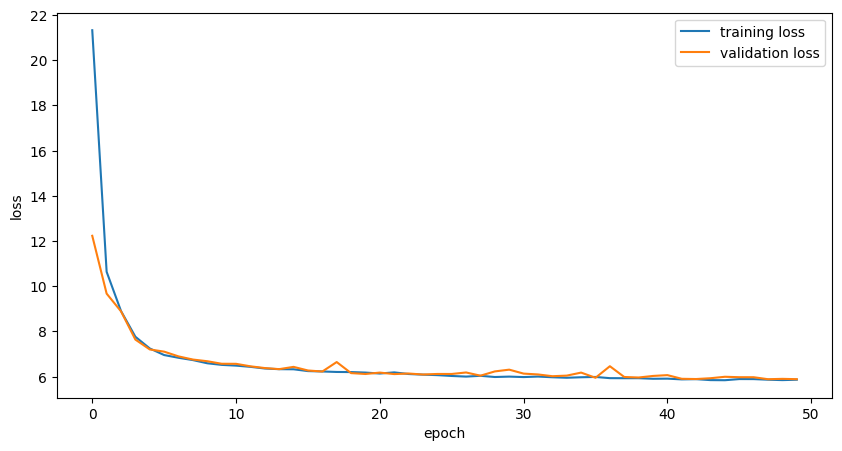

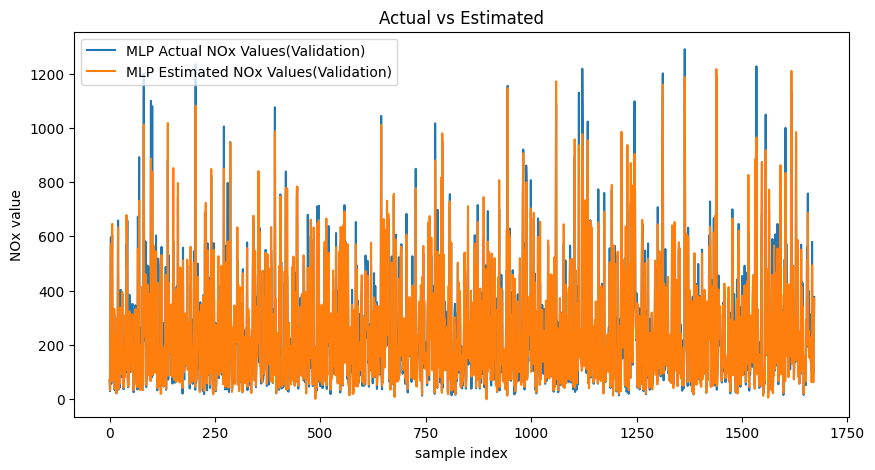

In [21]:
# reverse scaled loss
training_loss_scaled = scaler_labels.inverse_transform(np.array(history.history['loss']).reshape(-1, 1)).flatten()
validation_loss_scaled = scaler_labels.inverse_transform(np.array(history.history['val_loss']).reshape(-1, 1)).flatten()


plt.figure(figsize=(10, 5))
plt.plot(training_loss_scaled, label='training loss')
plt.plot(validation_loss_scaled, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# test_predictions = regression_model.predict(test_features)
plt.figure(figsize=(10, 5))
plt.plot(test_labels, label='MLP Actual NOx Values(Validation)')
plt.plot(test_predictions, label='MLP Estimated NOx Values(Validation)')
plt.title('Actual vs Estimated')
plt.xlabel('sample index')
plt.ylabel('NOx value')
plt.legend()
plt.show()

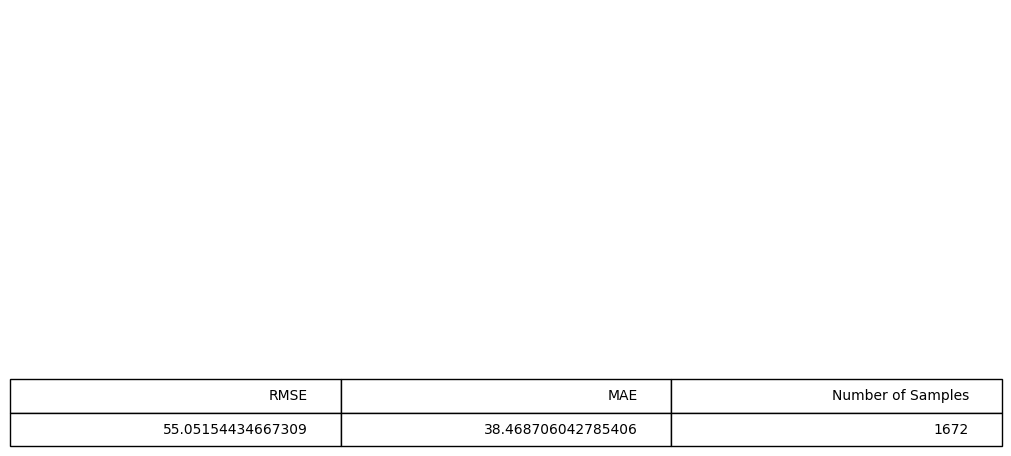

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
#learn from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html and https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html
#compare with mse, rmse is more sensitive to large loss. It is a better choice to reflect how outlier affects model
#mae reflects difference between prediction and actual
rmse = np.sqrt(mean_squared_error(test_labels, test_predictions))
mae = mean_absolute_error(test_labels, test_predictions)

regression_task_data = [['RMSE', 'MAE','Number of Samples'],
        [rmse, mae, len(test_labels) ]]
fig, ax = plt.subplots()
ax.axis('off')
table = ax.table(cellText=regression_task_data)
table.scale(2, 2)
plt.show()

____________________________________________________________________________________________________________________________________________________________
The following is my code for marking dataset

need to modify file_path_new = 'AirQualityUCI _ Students.xlsx'  
change 'AirQualityUCI _ Students.xlsx'

In [29]:
#save the model to local storage
classification_model.save('classification_model_yixuan.keras')
regression_model.save('regression_model_yixuan.keras')

In [30]:
#load the local model 
classification_model_path = 'classification_model_yixuan.keras'
classification_model = tf.keras.models.load_model(classification_model_path)

regression_model_path = 'regression_model_yixuan.keras'
regression_model = tf.keras.models.load_model(regression_model_path)

upload test data and modify this dataset

In [33]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

file_path_new = 'AirQualityUCI _ Students.xlsx'
new_data = pd.read_excel(file_path_new)

new_data.replace(-200, np.nan, inplace=True)
new_data.interpolate(method='linear', inplace=True)
new_data['DayOfYear'] = pd.to_datetime(new_data['Date'], format='%Y-%m-%d').dt.dayofyear
new_data['HourOfDay'] = pd.to_datetime(new_data['Time'], format='%H:%M:%S').dt.hour
co_mean = new_data['CO(GT)'].mean()
new_data['CO_INT'] = (new_data['CO(GT)'] > co_mean).astype(int)

C:\Users\lu\AppData\Local\Temp\ipykernel_20496\1321925263.py:14: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  new_data.interpolate(method='linear', inplace=True)


For classification task:

262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step
Classification predictions (new data):
[1 0 1 1 0 0 0 0 0 0]


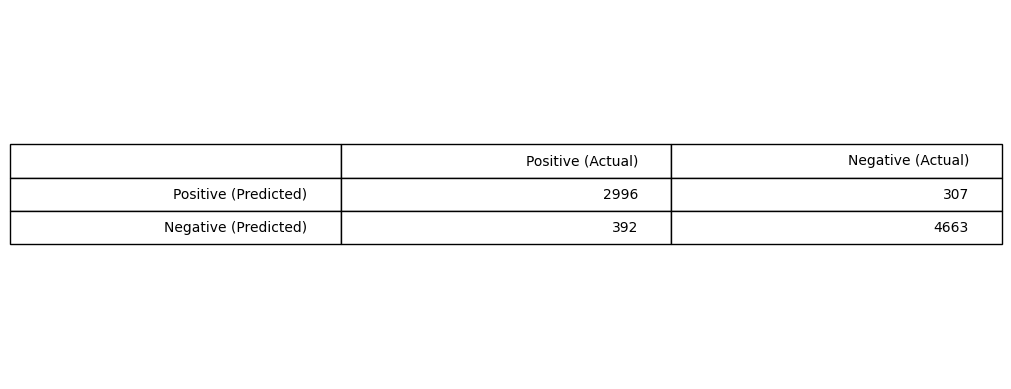

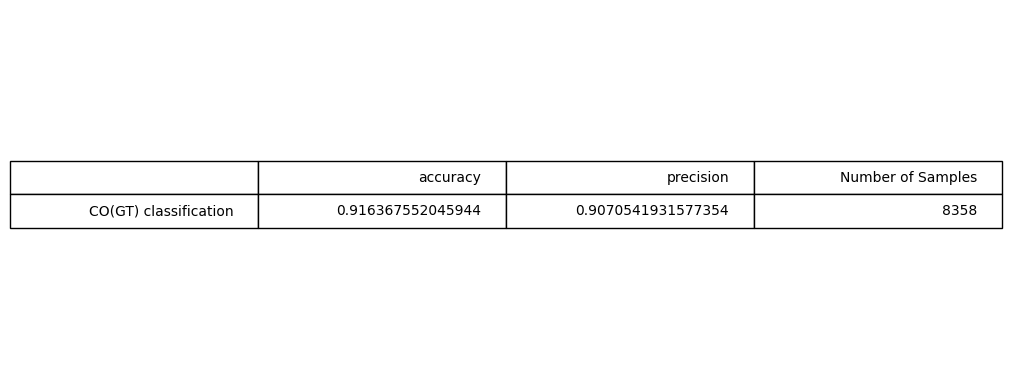

In [34]:
classification_scaler_new = MinMaxScaler()
classification_features_new = new_data.drop(columns=['Date', 'Time', 'CO(GT)', 'CO_INT'])
classification_labels_new = new_data['CO_INT']

classification_features_scaled_new = classification_scaler_new.fit_transform(classification_features_new)


classification_predictions_new = classification_model.predict(classification_features_scaled_new).flatten()
classification_predictions_new = (classification_predictions_new > 0.5).astype(int)
print("Classification predictions (new data):")
print(classification_predictions_new[:10])

conf_matrix = confusion_matrix(classification_labels_new, classification_predictions_new)
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]

classification_accuracy = (TP + TN) / (TP + TN + FP + FN)
if (TP + FP) != 0:
    classification_precision = TP / (TP + FP)
else:
    classification_precision = 0

confusion_matrix_data = [['', 'Positive (Actual)', 'Negative (Actual)'],
        ['Positive (Predicted)', TP, FP],
        ['Negative (Predicted)', FN, TN]]
fig, ax = plt.subplots()
ax.axis('off')
table = ax.table(cellText=confusion_matrix_data, loc='center')
table.scale(2, 2)
plt.show()

classification_precision_accuracy_data = [['', 'accuracy', 'precision', 'Number of Samples'],
        ['CO(GT) classification', classification_accuracy, classification_precision, len(classification_labels_new)]]
fig, ax = plt.subplots()
ax.axis('off')
table = ax.table(cellText=classification_precision_accuracy_data, loc='center')
table.scale(2, 2)
plt.show()

For regression task:

262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step


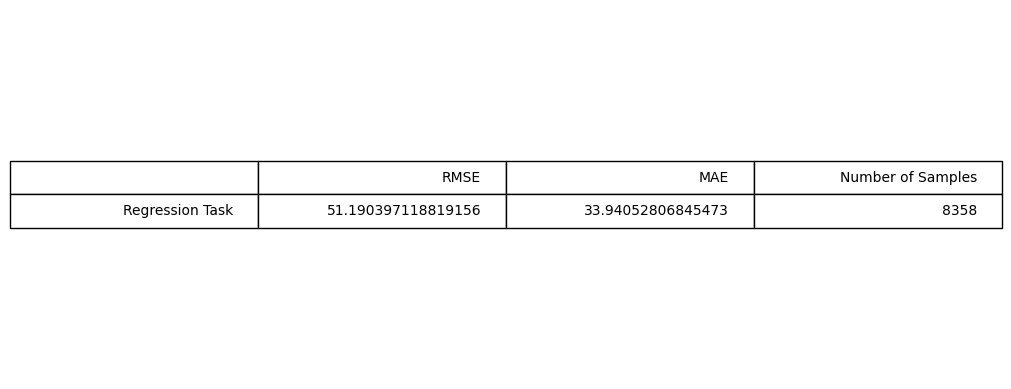

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


regression_features_new = new_data.drop(columns=['Date', 'Time', 'CO_INT', 'NOx(GT)'])
regression_labels_new = new_data['NOx(GT)']

regression_scaled_features_new = scaler_features.transform(regression_features_new)

regression_predictions_new = regression_model.predict(regression_scaled_features_new).flatten()
regression_predictions_new = scaler_labels.inverse_transform(regression_predictions_new.reshape(-1, 1)).flatten()

rmse = np.sqrt(mean_squared_error(regression_labels_new, regression_predictions_new))
mae = mean_absolute_error(regression_labels_new, regression_predictions_new)

regression_task_data = [['', 'RMSE', 'MAE', 'Number of Samples'],
        ['Regression Task', rmse, mae, len(regression_labels_new)]]
fig, ax = plt.subplots()
ax.axis('off')
table = ax.table(cellText=regression_task_data, loc='center')
table.scale(2, 2)
plt.show()